The objective of the below work is to create human like sketches from real face images.
1. For this I have choosen the celebA dataset(downscaled 256) -[CelebA-HQ resized (256x256)](https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256/data)
2. I have tried out 3 edge detection techniques canny, HED and XDOG

In [2]:
#Connecting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
from skimage.morphology import thin
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.utils as vutils
import csv
import pandas as pd
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
from skimage.metrics import structural_similarity as SSIM
from skimage.io import imread
from skimage.transform import resize



In [4]:
image_path = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/image'

In [5]:
image_files = sorted([os.path.join(image_path, fname) for fname in os.listdir(image_path) if fname.endswith(('.jpg','.png'))])

In [5]:
print(len(image_files))

30000


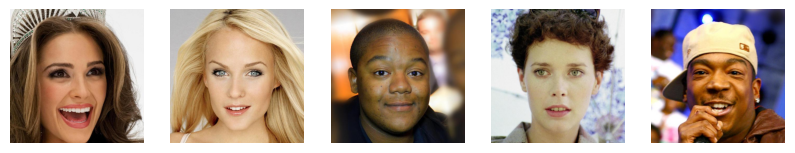

In [6]:
#plot the images
def plot_images(img_files,n):
  plt.figure(figsize=(10,10))
  for i in range(n):
    img = cv2.imread(img_files[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.axis('off')

plot_images(image_files,5)

In [7]:
image = cv2.imread(image_files[0])
print("Image shape:", image.shape)

Image shape: (512, 512, 3)


In [ ]:
#creating a test image
train_images = image_files[:10000]
test_images = image_files[10000:15000]

## Canny Edge Detection


In [ ]:
#Before applying canny make a file for the canny sketches
canny_sketch_folder = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/Canny1000'
os.makedirs(canny_sketch_folder, exist_ok=True)

In [ ]:
#Just to check the how well canny detect edges first I will do a test run
test_images = image_files[:1000]

In [ ]:
def canny_process(test_images, canny_sketch_folder):
  for i, path in enumerate(test_images):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Gaussian Blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Auto Canny
    v = np.median(blur)
    lower = int(max(0, (1.0 - 0.33) * v))
    upper = int(min(255, (1.0 + 0.33) * v))
    canny = cv2.Canny(blur, lower, upper)

    # Invert edges
    inverted_edges = cv2.bitwise_not(canny)

    # Save
    filename = os.path.basename(path)
    output_path = os.path.join(canny_sketch_folder, filename)
    cv2.imwrite(output_path, inverted_edges)

    if (i + 1) % 10 == 0:
      print(f"Processed {i + 1}/{len(test_images)} images")

  print("All images processed and saved.")


In [ ]:
canny_process(test_images, canny_sketch_folder)

Processed 10/1000 images
Processed 20/1000 images
Processed 30/1000 images
Processed 40/1000 images
Processed 50/1000 images
Processed 60/1000 images
Processed 70/1000 images
Processed 80/1000 images
Processed 90/1000 images
Processed 100/1000 images
Processed 110/1000 images
Processed 120/1000 images
Processed 130/1000 images
Processed 140/1000 images
Processed 150/1000 images
Processed 160/1000 images
Processed 170/1000 images
Processed 180/1000 images
Processed 190/1000 images
Processed 200/1000 images
Processed 210/1000 images
Processed 220/1000 images
Processed 230/1000 images
Processed 240/1000 images
Processed 250/1000 images
Processed 260/1000 images
Processed 270/1000 images
Processed 280/1000 images
Processed 290/1000 images
Processed 300/1000 images
Processed 310/1000 images
Processed 320/1000 images
Processed 330/1000 images
Processed 340/1000 images
Processed 350/1000 images
Processed 360/1000 images
Processed 370/1000 images
Processed 380/1000 images
Processed 390/1000 im

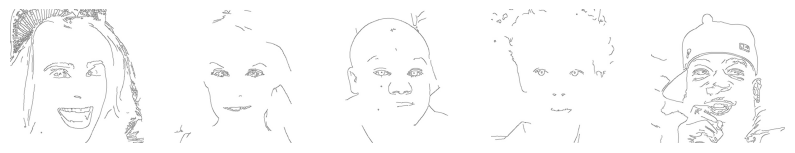

In [ ]:
#plot the sketches
sketch_files = sorted([os.path.join(canny_sketch_folder, fname) for fname in os.listdir(canny_sketch_folder) if fname.endswith(('.jpg','.png'))])
def plot_images(sketch_files,n):
  plt.figure(figsize=(10,10))
  for i in range(n):
    img = cv2.imread(sketch_files[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.axis('off')

plot_images(sketch_files,5)


## HED

To implement HED you need to download the pretrained caffe model and the prototext file.

In [ ]:
#crop layer class
class CropLayer(object):
    def __init__(self, params, blobs):
        self.startX = 0
        self.endX = 0
        self.starty = 0
        self.endy = 0
    def getMemoryShapes(self, inputs):
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (height, width) = (targetShape[2], targetShape[3])

        # Compute the starting and ending crop coordination
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.endX = self.startX + width
        self.starty = int((inputShape[2] - targetShape[2]) / 2)
        self.endy = self.starty + height

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:, :, self.starty:self.endy, self.startX:self.endX]]

In [ ]:
#The pre-trained model that I am using here is trained in caffe model
proto_path = '/content/drive/MyDrive/FinalYearProject/Datasets/HED/deploy.prototxt'
model_path = '/content/drive/MyDrive/FinalYearProject/Datasets/HED/hed_pretrained_bsds.caffemodel'

net = cv2.dnn.readNetFromCaffe(proto_path, model_path)

In [ ]:
#registering the crop layer
cv2.dnn_registerLayer('Crop', CropLayer)


In [ ]:
#Setting Up paths and creating a HED_sketch folder
image_path = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/image'
HED_sketch_folder = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/HEDtrain10000'
os.makedirs(HED_sketch_folder, exist_ok=True)

In [ ]:
#Use this when all the pre-processing parts are done finalize the last edge(sketch images)
'''image_path = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/image'
HED_final_folder = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/FinalSketches'

os.makedirs(HED_final_folder, exist_ok= True)

output_path = os.path.join(HED_final_folder, os.path.basename(img_path))
cv2.imwrite(output_path, edge_images)'''



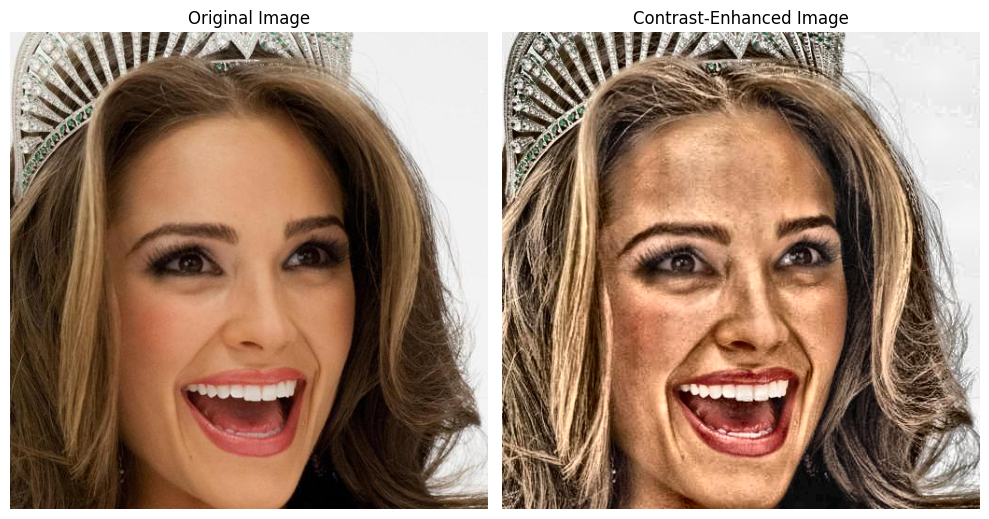

In [ ]:
#Testing out contrast vs original
import cv2
import matplotlib.pyplot as plt

# Pick one image
sample_path = image_files[0]  # Or choose any: image_files[100], etc.

# Load original image and convert to RGB
original = cv2.imread(sample_path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Enhance contrast using CLAHE
def enhance_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16, 16))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_image

enhanced = enhance_contrast(original_rgb)

# Plot both images side by side
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced)
plt.title('Contrast-Enhanced Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#Applying HED
def HED_process(image):
  #blob creation
  blob = cv2.dnn.blobFromImage(image, scalefactor=1.0,
        size=(image.shape[1], image.shape[0]),
        mean=(104.00698793, 116.66876762, 122.67891434),
        swapRB=False,
        crop=False
        )
  net.setInput(blob)
  hed = net.forward()
  hed = hed[0, 0, :, :]  # Get the single-channel edge map
  hed = (255 * hed).astype("uint8")
  return hed

In [ ]:
'''#contrast before binarization
def enhance_and_binarize(image):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  enhanced = clahe.apply(image)
  return enhanced'''

'#contrast before binarization\ndef enhance_and_binarize(image): \n  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))\n  enhanced = clahe.apply(image)\n  return enhanced'

In [ ]:
#binarization
#OTSU
def binarize_image(image):
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

'''# Adaptive thresholding
def binarize_adaptive(image):
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 2)
    return binary'''

#Histogram based Thresholding


'# Adaptive thresholding\ndef binarize_adaptive(image):\n    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 2)\n    return binary'

In [ ]:
#Thinning the Edges
#-----------------------------------1.ximgproc method----------------------------------------------------------------------------------------------------------------

'''def thinning_edges(image):
    thinning = cv2.ximgproc.thinning(image,thinningType=cv2.ximgproc.THINNING_GUOHALL)
    return thinning
'''
#-----------------------------------2.skimage.morphology.thin method--------------------------------------------------------------------------------------------------

def thinning_edges(image):
    binary = image // 255
    thinned = thin(binary)
    thinned = (thinned * 255).astype(np.uint8)
    return thinned

In [ ]:
#small component removal
def remove_small_components(image, min_size = 20):
  num_labels, labels = cv2.connectedComponents(image)
  cleaned = np.zeros(image.shape, dtype=np.uint8)

  for label in range(1, num_labels):
    area = np.sum(labels == label)
    if area >= min_size:
      cleaned[labels == label] = 255
  return cleaned

In [ ]:
#Benchmark and visualizing

'''
# CLAHE contrast enhancement
def clahe_process(image):
  lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16, 16))
  cl = clahe.apply(l)
  enhanced_lab = cv2.merge((cl, a, b))
  contrasted_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
  return contrasted_image
'''

  #batch processing with benchmarks and vizualization
def process_image_batches(batch_size = 1000, visualize_every=200):
  total = len(train_images)
  for i in range(0, total, batch_size):
    batch = train_images[i:i+batch_size]
    print(f"\n processing batch {i} to {i + len(batch) - 1}..."  )

    start_time = time.time()
    for j,path in enumerate(tqdm(batch)):
      filename = os.path.basename(path)
      save_path = os.path.join(HED_sketch_folder, filename)

      #skip if already process
      if os.path.exists(save_path):
        continue

      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      #contrast_image = clahe_process(image)
      #contrast_image_bgr = cv2.cvtColor(contrast_image, cv2.COLOR_RGB2BGR)
      hed_result = HED_process(image) #'contrast_image_bgr' should be here if you gonna use contrased images
     # hed_result = crop_image(hed_result)
      hed_result = binarize_image(hed_result)
      hed_result = thinning_edges(hed_result)
      hed_result = remove_small_components(hed_result)
      cv2.imwrite(save_path, hed_result)

      #Visualize images
      if j % visualize_every == 0:
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title('Original')
        plt.axis('off')

        '''plt.subplot(1,3,2)
        plt.imshow(contrast_image)
        plt.title('Contrast Enhanced')
        plt.axis('off')'''

        plt.subplot(1,2,2)
        plt.imshow(hed_result, cmap='gray')
        plt.title('HED Sketch')
        plt.axis('off')

        plt.suptitle(f'Sample from Batch {i}-{i+batch_size-1}')
        plt.show()
        plt.close()
  end_time = time.time()
  duration = end_time - start_time
  print(f"Finished batch {i} to {i + len(batch) - 1} in {duration:.2f} seconds.")


 processing batch 0 to 499...


  0%|          | 0/500 [00:00<?, ?it/s]

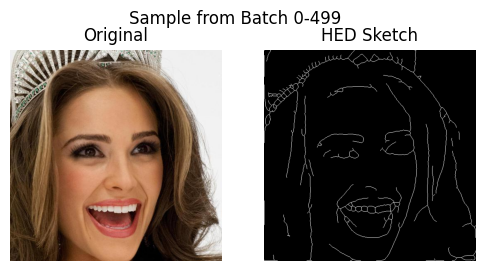

 40%|████      | 200/500 [03:20<05:20,  1.07s/it]

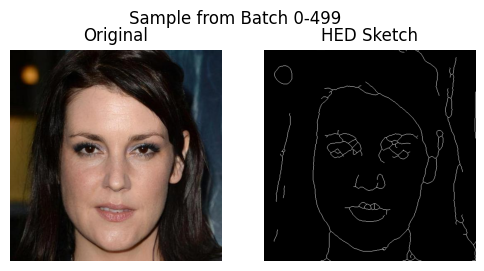

 80%|████████  | 400/500 [06:42<01:43,  1.04s/it]

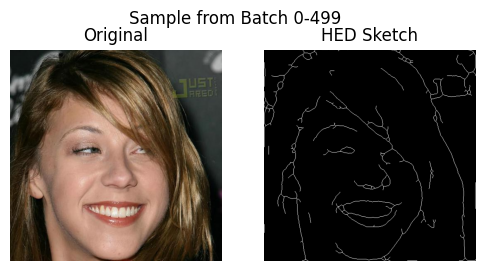

100%|██████████| 500/500 [08:23<00:00,  1.01s/it]



 processing batch 500 to 999...


  0%|          | 0/500 [00:00<?, ?it/s]

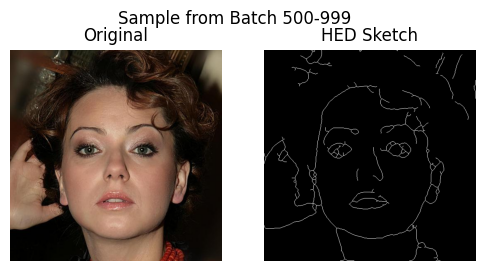

 40%|████      | 200/500 [03:21<04:51,  1.03it/s]

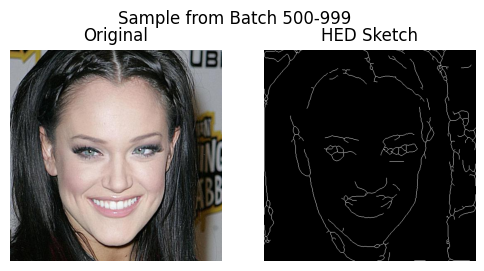

 80%|████████  | 400/500 [06:43<01:44,  1.04s/it]

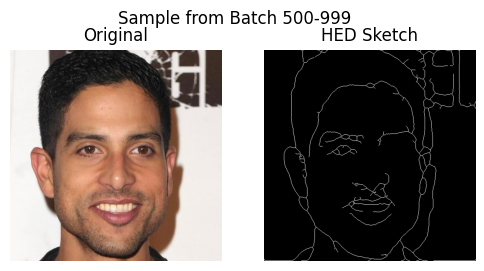

100%|██████████| 500/500 [08:25<00:00,  1.01s/it]



 processing batch 1000 to 1499...


  0%|          | 0/500 [00:00<?, ?it/s]

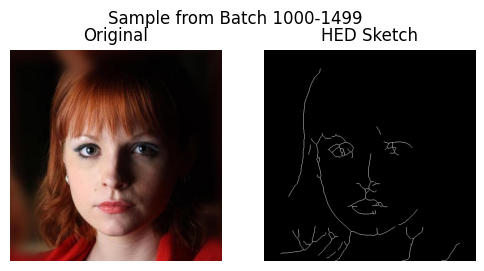

 40%|████      | 200/500 [03:22<05:11,  1.04s/it]

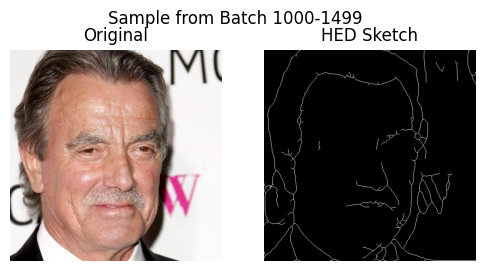

 80%|████████  | 400/500 [06:44<01:45,  1.05s/it]

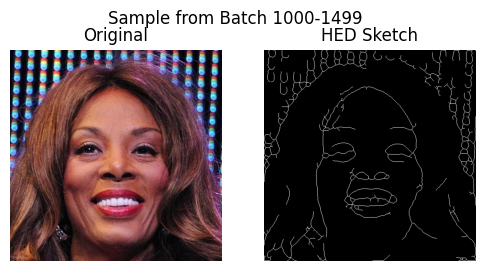

100%|██████████| 500/500 [08:27<00:00,  1.01s/it]



 processing batch 1500 to 1999...


  0%|          | 0/500 [00:00<?, ?it/s]

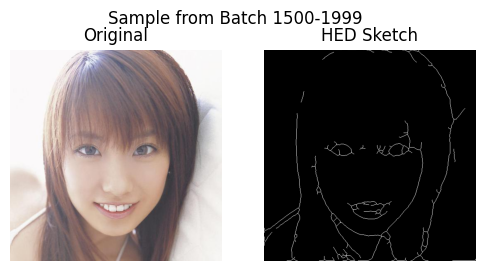

 40%|████      | 200/500 [03:22<05:08,  1.03s/it]

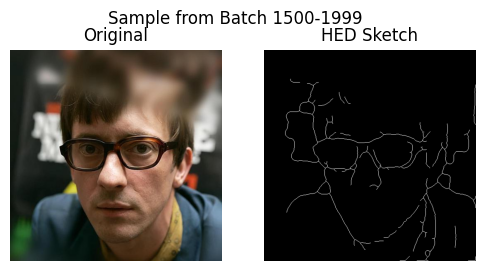

 80%|████████  | 400/500 [06:45<01:37,  1.02it/s]

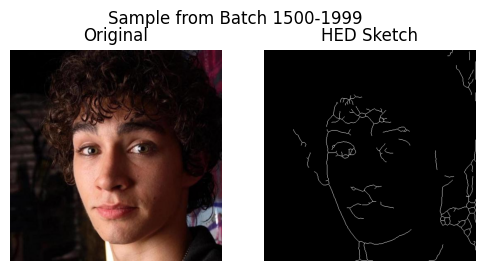

100%|██████████| 500/500 [08:27<00:00,  1.01s/it]



 processing batch 2000 to 2499...


  0%|          | 0/500 [00:00<?, ?it/s]

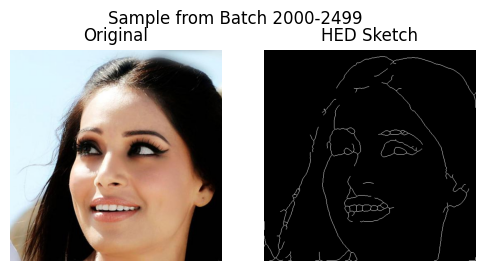

 40%|████      | 200/500 [03:21<05:00,  1.00s/it]

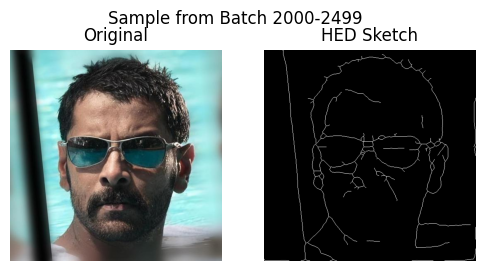

 80%|████████  | 400/500 [06:42<01:37,  1.02it/s]

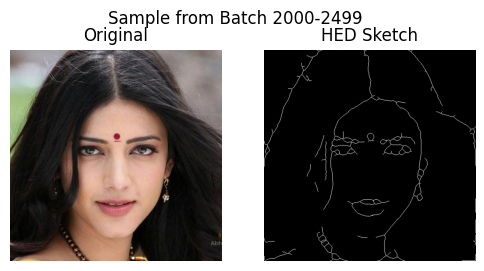

100%|██████████| 500/500 [08:23<00:00,  1.01s/it]



 processing batch 2500 to 2999...


  0%|          | 0/500 [00:00<?, ?it/s]

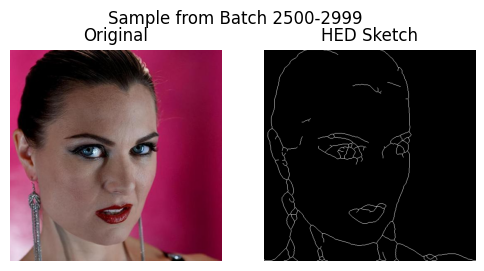

 40%|████      | 200/500 [03:24<05:06,  1.02s/it]

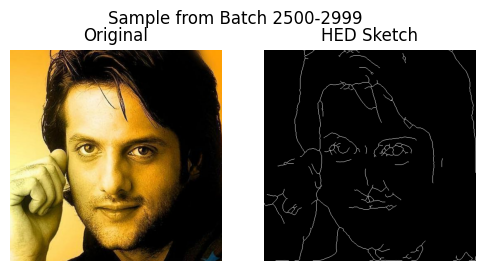

 80%|████████  | 400/500 [06:50<01:45,  1.06s/it]

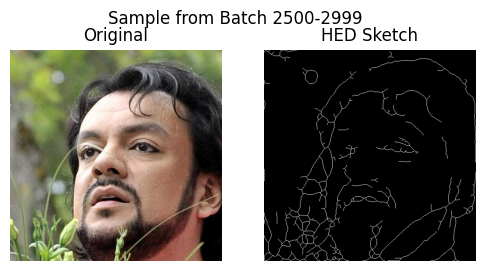

100%|██████████| 500/500 [08:32<00:00,  1.02s/it]



 processing batch 3000 to 3499...


  0%|          | 0/500 [00:00<?, ?it/s]

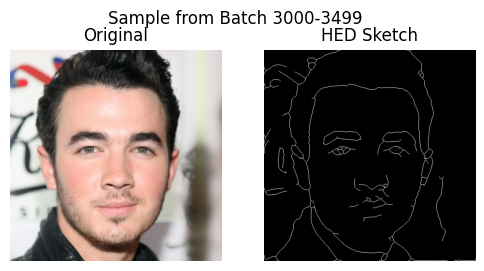

 40%|████      | 200/500 [03:21<04:48,  1.04it/s]

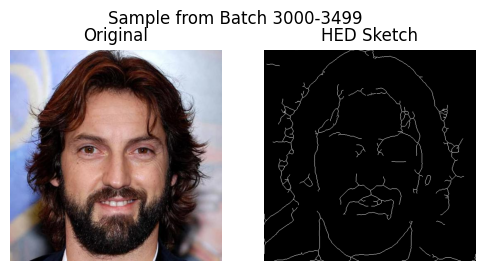

 61%|██████    | 305/500 [05:07<03:16,  1.01s/it]

In [ ]:
process_image_batches(batch_size=500, visualize_every=200)

# Pix2Pix

## Models

### Attention Mechanism

In [6]:
#attention block
class AttentionBlock(nn.Module):
  def __init__(self, F_g, F_l, F_int):
    super(AttentionBlock, self).__init__()
    self.W_g = nn.Sequential(
        nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(F_int)
    )

    self.W_x = nn.Sequential(
        nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(F_int)
    )
    self.psi = nn.Sequential(
        nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(1),
        nn.Sigmoid()
    )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, g, x):
    g1 = self.W_g(g)
    x1 = self.W_x(x)
    psi = self.relu(g1 + x1)
    psi = self.psi(psi)

    return x * psi

In [7]:
class Attention(nn.Module):
  def __init__(self, in_channels=3, out_channels=3 ):
    super().__init__()

    #encoder layer
    self.encoder_1 = EncoderBlock(in_channels, 64, batch_norm=False)
    self.encoder_2 = EncoderBlock(64, 128)
    self.encoder_3 = EncoderBlock(128, 256)
    self.encoder_4 = EncoderBlock(256, 512)
    self.encoder_5 = EncoderBlock(512, 512)
    self.encoder_6 = EncoderBlock(512, 512)
    self.encoder_7 = EncoderBlock(512, 512)
    self.encoder_8 = EncoderBlock(512, 512, batch_norm=False)

    #decoder layer
    self.decoder_1 = DecoderBlock(512, 512, dropout=True)
    self.decoder_2 = DecoderBlock(1024, 512, dropout=True)
    self.decoder_3 = DecoderBlock(1024, 512, dropout=True)
    self.decoder_4 = DecoderBlock(1024, 512)
    self.decoder_5 = DecoderBlock(1024, 256)
    self.decoder_6 = DecoderBlock(512, 128)
    self.decoder_7 = DecoderBlock(256, 64)

    #final layer
    self.final_layer = nn.Sequential(
        nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

    # Attention blocks
    self.att7 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d1 and e7
    self.att6 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d2 and e6
    self.att5 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d3 and e5
    self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d4 and e4
    self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)  # d5 and e3
    self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)   # d6 and e2
    self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)     # d7 and e1

### Generator

#### Ecoder

In [8]:
class EncoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, batch_norm=True):
    super().__init__()
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
    if batch_norm:
      layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    self.encode = nn.Sequential(*layers)

  def forward(self, x):
    return self.encode(x)


#### Decoder

In [9]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout=False):
    super().__init__()
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
              ]
    if dropout:
      layers.append(nn.Dropout(0.5))#Dropouts are used to avoid overfitting
    self.decode = nn.Sequential(*layers)

  def forward(self, x):
    return self.decode(x)


#### Generator Class

In [10]:
from math import e
class Generator(nn.Module):
  def __init__(self, in_channels=3, out_channels=3):
    super().__init__()

    #Encorder layers
    self.encoder_1 = EncoderBlock(in_channels, 64, batch_norm=False) #(512 → 256)
    self.encoder_2 = EncoderBlock(64, 128) #(256 → 128)
    self.encoder_3 = EncoderBlock(128, 256) #(128 → 64)
    self.encoder_4 = EncoderBlock(256, 512) #(64 → 32)
    self.encoder_5 = EncoderBlock(512, 512) #(32 → 16)
    self.encoder_6 = EncoderBlock(512, 512) #(16 → 8)
    self.encoder_7 = EncoderBlock(512, 512) #(8 → 4)
    self.encoder_8 = EncoderBlock(512, 512, batch_norm=False) #(4 → 2)

    #Decoder layers
    self.decoder_1 = DecoderBlock(512, 512, dropout=True) #(2 → 4)
    self.decoder_2 = DecoderBlock(1024, 512, dropout=True) #(4 → 8)
    self.decoder_3 = DecoderBlock(1024, 512, dropout=True) #(8 → 16)
    self.decoder_4 = DecoderBlock(1024, 512) #(16 → 32)
    self.decoder_5 = DecoderBlock(1024, 256) #(32 → 64)
    self.decoder_6 = DecoderBlock(512, 128) #(64 → 128)
    self.decoder_7 = DecoderBlock(256, 64) #(128 → 256)

    #final layer
    self.final_layer = nn.Sequential(
        nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

            # Attention blocks
    self.att7 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d1 and e7
    self.att6 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d2 and e6
    self.att5 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d3 and e5
    self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # d4 and e4
    self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)  # d5 and e3
    self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)   # d6 and e2
    self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)     # d7 and e1

  def forward(self,x):
    #encoding path
    e1 = self.encoder_1(x)
    e2 = self.encoder_2(e1)
    e3 = self.encoder_3(e2)
    e4 = self.encoder_4(e3)
    e5 = self.encoder_5(e4)
    e6 = self.encoder_6(e5)
    e7 = self.encoder_7(e6)
    e8 = self.encoder_8(e7)

    #decoding + skip connections + attention
    d1 = self.decoder_1(e8)

    e7 = self.att7(d1, x=e7)
    d2 = self.decoder_2(torch.cat([d1, e7], dim=1))

    e6 = self.att6(d2, x=e6)
    d3 = self.decoder_3(torch.cat([d2, e6], dim=1))

    e5 = self.att5(d3, x=e5)
    d4 = self.decoder_4(torch.cat([d3, e5], dim=1))

    e4 = self.att4(d4, x=e4)
    d5 = self.decoder_5(torch.cat([d4, e4], dim=1))

    e3 = self.att3(d5, x=e3)
    d6 = self.decoder_6(torch.cat([d5, e3], dim=1))

    e2 = self.att2(d6, x=e2)
    d7 = self.decoder_7(torch.cat([d6, e2], dim=1))

    e1  = self.att1(d7, x=e1)
    out = self.final_layer(torch.cat([d7, e1], dim=1))
    #final layer
    return out

### Discriminator

#### Discriminator Class

In [11]:
class DiscriminatorBlock(nn.Module):
  def __init__(self, in_channels, out_channels, batch_norm=True):
    super().__init__()
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
    if batch_norm:
      layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

In [12]:
class Discriminator(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    #Input will be sketch + image = 3+3 = 6 channels
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2, inplace=True)
    )

    self.block1 = DiscriminatorBlock(64, 128) # 256 x 256
    self.block2 = DiscriminatorBlock(128, 256)# 128 x 128
    self.block3 = DiscriminatorBlock(256, 512)# 64 x 64
    self.block4 = DiscriminatorBlock(512, 512, batch_norm=False) # 32 x 32

    #final output(PatchGAN) - 31 x 31 if input is 512 x 512
    self.final = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')

  def forward(self, sketch, image):
    x = torch.cat([sketch, image], dim=1)
    x = self.initial(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return torch.sigmoid(x)


### Loss


In [13]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [14]:
import lpips

In [15]:
class loss_function(nn.Module):
  def __init__(self, lambda_ = 100, lambda_percep=15):
    super().__init__()
    self.adversarial_loss = nn.BCEWithLogitsLoss() #BCELoss was used in the original paper.BCEwithLogitsloss combines a Sigmoid layer and the BCELoss in one single class.
    self.perceptual_loss = lpips.LPIPS(net='vgg').to(device)
    self.perceptual_loss.eval()
    self.l1_loss = nn.L1Loss()
    self.lambda_ = lambda_
    self.lambda_percep = lambda_percep

  def forward(self, pred_fake, pred_real, gen_output, target):
    # Adversarial loss
    real_loss = self.adversarial_loss(pred_real, torch.ones_like(pred_real))
    fake_loss = self.adversarial_loss(pred_fake, torch.zeros_like(pred_fake))
    gan_loss = (real_loss + fake_loss) / 2

    # L1 loss
    l1_loss = self.l1_loss(gen_output, target)

    #total loss
    total_loss = gan_loss + self.lambda_ * l1_loss

    #Optional perceptual loss addition
    p_loss = self.perceptual_loss(gen_output, target).mean()

    total_loss += self.lambda_percep * p_loss

    return total_loss,gan_loss, l1_loss,p_loss

    # Optional perceptual loss (VGG-based)
    '''self.perceptual_loss = VGGPerceptualLoss()
    self.lambda_percep = 10  # Tune this based on performance
'''

### Dataloader

In [16]:
class Dataset(Dataset):
  def __init__(self, sketch_dir, image_dir, transform=None):
    self.sketch_dir = sketch_dir
    self.image_dir = image_dir
    self.transform = transform
    self.image_filenames = sorted(os.listdir(image_dir))
    self.sketch_filenames = sorted(os.listdir(sketch_dir))

  def __len__(self): #This will prevents the mismatch error
    return min(len(self.image_filenames), len(self.sketch_filenames))

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.image_filenames[index])
    sketch_path = os.path.join(self.sketch_dir, self.sketch_filenames[index])

    sketch = Image.open(sketch_path).convert('RGB')
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      sketch = self.transform(sketch)
      image = self.transform(image)

    return sketch, image

  #Defining my transform
transform = transforms.Compose([
      transforms.Resize((512, 512)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Normalize to [-1,1]


image_dir =  '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/image'
sketch_dir = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/HEDtrain10000'


dataset = Dataset(sketch_dir, image_dir, transform=transform)
train_ratio = 0.9 #9000 for training and 1000 for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset,[train_size, val_size])

train_loader = DataLoader(train_dataset,batch_size=10, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=2)


### Training Loop

In [17]:
def train(G, D, loss_func, train_loader, val_loader, device, num_epochs):
  g_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
  d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

  save_dir = "/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512"
  sample_dir = os.path.join(save_dir, "generated_vivatest")
  os.makedirs(sample_dir, exist_ok=True)

  #Lists to store the losses values for later plotting
  g_losses = []
  d_losses = []
  gan_losses = []
  l1_losses = []
  p_losses = []

  #set models to train mode
  G.train()
  D.train()


  step = 0

  for epoch in range(num_epochs):
    #Training loop
    for i, (sketch, real) in enumerate(train_loader):

      sketch, real = sketch.to(device), real.to(device)

      # Train Discriminator
      fake = G(sketch)
      pred_real = D(sketch, real)
      pred_fake = D(sketch, fake.detach())

      d_loss, _, _, _ = loss_func(pred_fake, pred_real, fake.detach(), real)
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()

      #Train Generator
      fake = G(sketch)
      pred_fake = D(sketch, fake)
      pred_real = D(sketch, real)
      g_loss, gan_loss, l1_loss,p_loss = loss_func(pred_fake, pred_real, fake, real, p_loss) #,p_loss (add this after l1_loss to get the perceptual results)

      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

      #Save losses in a python list
      g_losses.append(g_loss.item())
      d_losses.append(d_loss.item())
      gan_losses.append(gan_loss.item())
      l1_losses.append(l1_loss.item())
      p_losses.append(p_loss.item())

      print(f"Step {step}: D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}, GAN_loss: {gan_loss:.4f}, L1_loss: {l1_loss:.4f}, P_loss: {l1_loss:.4f}")

      #Save and vizualize every 100 steps including 0

      if step % 100 == 0:
        #save image
        for idx in range(fake.size(0)):
          image = fake[idx].detach().cpu()
          image = (image* 0.5 + 0.5).clamp(0, 1)
          image_pil = transforms.ToPILImage()(image)
          image_pil.save(f"{sample_dir}/fake_{step}_img{idx}.jpg")

        #VIsualize
                # Visualize first image in the batch
      if step % 300 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(sketch[0].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
        axs[0].set_title("Sketch")
        axs[1].imshow(real[0].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
        axs[1].set_title("Real")
        axs[2].imshow(fake[0].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
        axs[2].set_title("Generated")
        for ax in axs:
          ax.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

      step += 1

    #Validation loop after every epoch
    with torch.no_grad():
      G.eval() # Switch G to evaluation mode
      D.eval() # Switch D to evaluation mode

      val_loss = 0
      val_steps = 0

      for sketch,real in val_loader:
        sketch, real = sketch.to(device), real.to(device)

        fake = G(sketch)
        pred_fake = D(sketch, fake)
        pred_real = D(sketch, real)

        val_g_loss, val_gan_loss, val_l1_loss, val_p_loss = loss_func(pred_fake, pred_real, fake, real) #Add this , val_p_loss after val_l1_loss

        val_loss += val_g_loss.item()
        val_steps += 1

      val_loss /= val_steps
      print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

      #Set back to traning mode
      G.train()
      D.train()

    #Saving losses to a CSV file after training
    log_files = os.path.join(save_dir, "losses.csv")
    with open(log_files, mode= "w", newline='') as f:
      writer = csv.writer(f)
      writer.writerow(["Steps", "D_loss", "G_loss", "GAN_loss", "L1_loss","p_loss"]) #,"p_loss"

      for i in range(len(g_losses)):
            writer.writerow([i, d_losses[i], g_losses[i], gan_losses[i], l1_losses[i], p_losses[i]]) #, p_losses[i]

    print("Training Complete!")

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(in_channels=3, out_channels=3).to(device)
D = Discriminator(in_channels=3).to(device)
loss_func = loss_function(lambda_=100, lambda_percep=15).to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
train(G, D, loss_func, train_loader, val_loader, device, num_epochs=10)

# Evaluation

In [ ]:
#Plotting the graphs of losses.
csv_losses_file = "/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/losses.csv"
losses = pd.read_csv(csv_losses_file)
print(losses.columns)

Index(['Steps', 'D_loss', 'G_loss', 'GAN_loss', 'L1_loss', 'p_loss'], dtype='object')


In [ ]:
loss_names = ['D_loss', 'G_loss', 'GAN_loss', 'L1_loss'] #,'p_loss'

#saving the grphs
plot_path = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/Loss_plotsatten'
os.makedirs(plot_path, exist_ok=True)

for loss in loss_names:
  plt.figure(figsize=(8,4))
  plt.plot(losses['Steps'], losses[loss], label=loss)
  plt.xlabel('Steps')
  plt.ylabel(loss)
  plt.title(f'{loss} over Traning')

  plt.savefig(os.path.join(plot_path, f'{loss}_plot.png'))
  plt.close()


Evaluation Metrices (IS,SSIM,PNSR)

In [ ]:
#Filtering out the ground truths
import shutil
# Define paths
generated_path = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/generated_samples'
real_image_path = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/image'
ground_truth_output = '/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/ground_truth'

# Make sure output folder exists
os.makedirs(ground_truth_output, exist_ok=True)

# List of filenames in generated_samples
image_files = os.listdir(generated_path)

# Copy corresponding real images
copied = 0
for filename in image_files:
    src = os.path.join(real_image_path, filename)
    dst = os.path.join(ground_truth_output, filename)

    if os.path.exists(src):
        shutil.copy2(src, dst)
        copied += 1
    else:
        print(f"[WARNING] Real image not found for: {filename}")

print(f"✅ Copied {copied} real images to ground_truth folder.")


[WARNING] Real image not found for: fake_0_img0.jpg
[WARNING] Real image not found for: fake_0_img1.jpg
[WARNING] Real image not found for: fake_100_img0.jpg
[WARNING] Real image not found for: fake_100_img1.jpg
[WARNING] Real image not found for: fake_200_img0.jpg
[WARNING] Real image not found for: fake_200_img1.jpg
[WARNING] Real image not found for: fake_300_img0.jpg
[WARNING] Real image not found for: fake_300_img1.jpg
[WARNING] Real image not found for: fake_400_img0.jpg
[WARNING] Real image not found for: fake_400_img1.jpg
[WARNING] Real image not found for: fake_500_img0.jpg
[WARNING] Real image not found for: fake_500_img1.jpg
[WARNING] Real image not found for: fake_600_img0.jpg
[WARNING] Real image not found for: fake_600_img1.jpg
[WARNING] Real image not found for: fake_700_img0.jpg
[WARNING] Real image not found for: fake_700_img1.jpg
[WARNING] Real image not found for: fake_800_img0.jpg
[WARNING] Real image not found for: fake_800_img1.jpg
[WARNING] Real image not found f

In [ ]:
#IS
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.fc = nn.Identity() # Remove the Final FC layer so we can access features
inception_model.eval()
inception_model.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
class FlatFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure RGB
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
#image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

generated_dataset = FlatFolderDataset(
    folder_path='/content/drive/MyDrive/FinalYearProject/Datasets/CelebAMask512/generated_samples',
    transform=transform
)
generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
def calculate_is(dataLoader, inception_model, splits =10):
  preds = []

  for batch in tqdm(generated_dataloader):
    batch = batch.cuda()
    with torch.no_grad():
      output = inception_model(batch)
      softmax_output = F.softmax(output, dim=1)
      preds.append(softmax_output.cpu().numpy())

  preds = np.concatenate(preds, 0)
  scores = []

  #Spilt into parts to get stable estimate
  N = preds.shape[0]
  split_size = N // splits

  for k in range(splits):
      part = preds[k * split_size: (k+1) * split_size, :]
      py = np.mean(part, axis=0)
      scores.append(np.exp(np.mean([
            np.sum(p * (np.log(p) - np.log(py))) for p in part
        ])))

  return np.mean(scores), np.std(scores)

In [ ]:
mean_IS, std_IS = calculate_is(generated_dataloader, inception_model, splits=10)

print(f"Inception Score: {mean_IS:.4f} ± {std_IS:.4f}")

100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


Inception Score: 1.0350 ± 0.0039


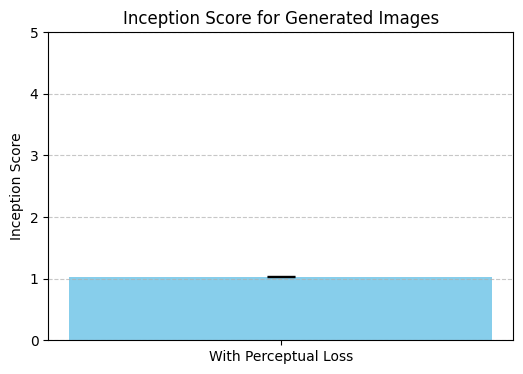

In [ ]:
import matplotlib.pyplot as plt

# Create a simple bar chart
labels = ['With Perceptual Loss']
scores = [mean_IS]
errors = [std_IS]

plt.figure(figsize=(6, 4))
plt.bar(labels, scores, yerr=errors, capsize=10, color='skyblue')
plt.ylabel('Inception Score')
plt.title('Inception Score for Generated Images')
plt.ylim(0, 5)  # Adjust depending on your scores range
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.savefig('/content/drive/MyDrive/FinalYearProject/Datasets')

plt.show()
